#                 Techkriti ML Hackathon 2k21
![Techkriti Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Techkriti_logo.png/220px-Techkriti_logo.png)

# Details of Hackathon
* Competition Task : **Image Classification**
* Library used : **TensorFlow**
* Classes Present : **6 (Buildings,Forest,Glacier,Mountain,Street,Sea)**
* Transfer Learning : **Yes**
* Metric used for Testing : **Accuracy**

In [ ]:
#Importing necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow.keras.layers import *

In [ ]:
# Creating necessary constants
# Change the paths accordingly if you change the location of dataset
MAIN_PATH = os.getcwd()
MAIN_PATH = MAIN_PATH[:-5]
TRAIN_PATH = os.path.join(MAIN_PATH,"dataset/seg_train/seg_train")
VAL_PATH = os.path.join(MAIN_PATH,"dataset/seg_test/seg_test")
BATCH_SIZE = 32
HEIGHT,WIDTH = 150,150
NUM_CLASSES = len(os.listdir(TRAIN_PATH))

# Creating Data Pipeline

1. I used `Image Data Generator` of Tensorflow to add augmentations to the training data to make sure that the model is not overfitting.
2. In case of `valid`,`test` datagen only rescaling is done.
3. Next I used the `datagen` and `flow_from_directory` to create the dataset in batches.

In [ ]:
def create_datagen(data_type = "train"):
    if data_type == "train":
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2
   )
    elif data_type == "valid":
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
   )
    else:
        print("Improper String given as input, Only one of ['train','valid','test'] should be given")
        datagen = None
    return datagen

def create_dataset(datagen,path,data_type="train"):
    if data_type == "train":
        dataset =datagen.flow_from_directory(
                         path,
                         target_size = (HEIGHT,WIDTH),
                         batch_size = BATCH_SIZE,
                         class_mode = "categorical",
                         shuffle = True
                            )
    elif data_type == "valid":
        dataset = datagen.flow_from_directory(
                      path,
                      target_size = (HEIGHT,WIDTH),
                      shuffle = False
                       )
    else:
        print("Improper String given as input, Only one of ['train','valid'] should be given")
        dataset = None
    return dataset


train_datagen = create_datagen("train")
val_datagen = create_datagen("valid")

train_ds = create_dataset(train_datagen,TRAIN_PATH,"train")
val_ds = create_dataset(val_datagen,VAL_PATH,"valid")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Data Visualization

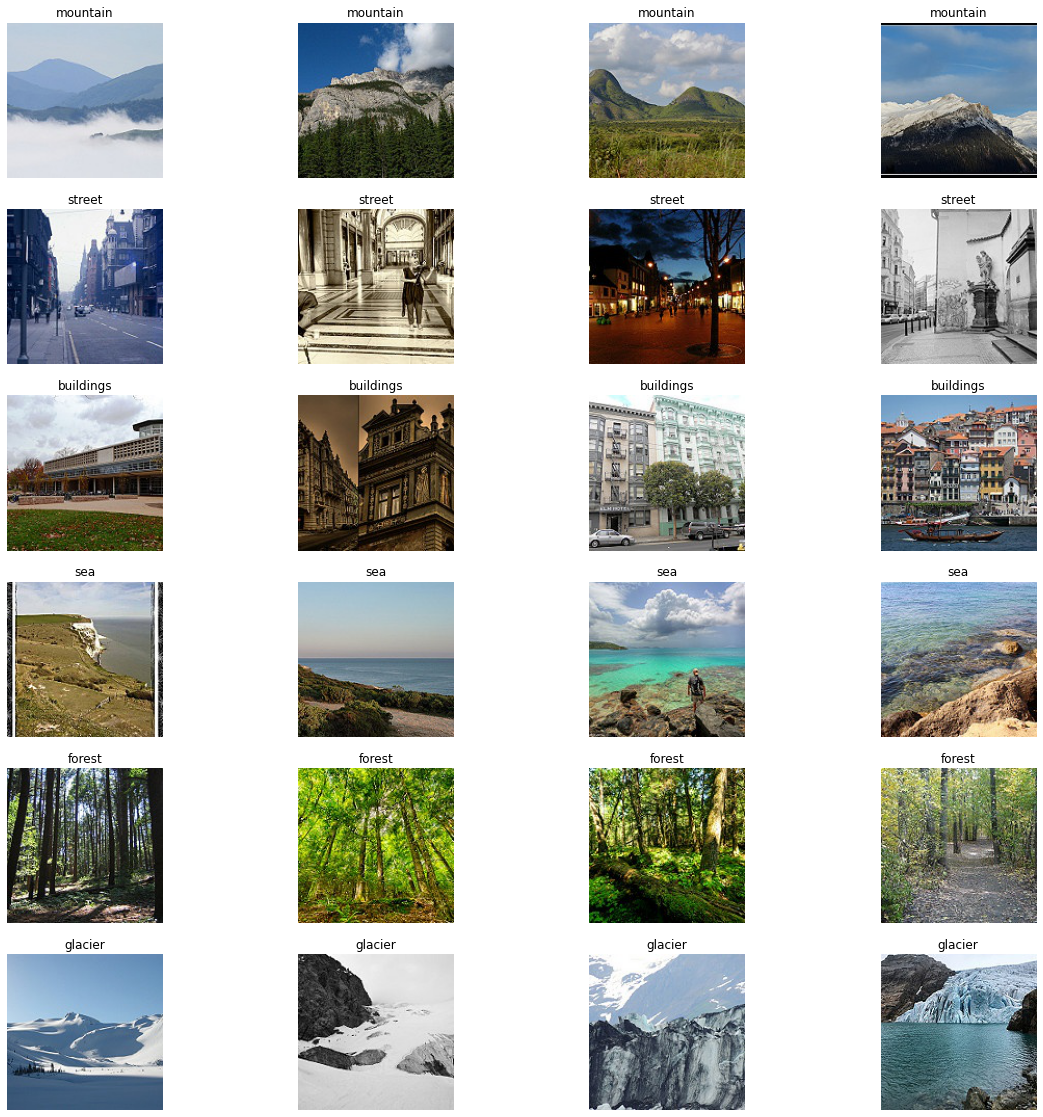

In [ ]:
plt.figure(figsize=(20,20))

for i,folder in enumerate(os.listdir(TRAIN_PATH)):
    path = os.path.join(TRAIN_PATH,folder)
    img_ls = os.listdir(path)
    for j,im_name in enumerate(img_ls[:4]):
        plt.subplot(6,4,4*i+j+1)
        img_path = os.path.join(path,im_name)
        img = PIL.Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(folder)

# Creating Model

1. I used pretrained models for this task. **`ImageNet`** weights are used. 
2. I also added few FC layers at the top of pretrained model.
3. Finally a softmax layer is added to get the probabilities of each class for a given Image.

In [ ]:
def create_model():
    pretrained = tf.keras.applications.DenseNet201(include_top=False,
                                                      weights='imagenet',
                                                      pooling="avg",
                                                      input_shape=[HEIGHT,WIDTH, 3])
    
    x = pretrained.output
    x = tf.keras.layers.Dropout(0.3) (x)
    x = tf.keras.layers.Dense(128) (x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
    x = tf.keras.layers.GaussianDropout(0.4) (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax", dtype='float32')(x)
        
    model = tf.keras.Model(pretrained.input, outputs)
    return model

# Compiling the Model

* Metric used for Training : **Categorical Accuracy**
* Optimizer for Taining : **Adam**
* Loss function for Training : **Categorical Cross Entropy**

In [ ]:
def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
        
    metrics = [
       tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Callbacks

* Callbacks are used to go through the results of train,valid after every epoch or evry run and make necessary changes or save the model etc.,
* I used 3 callbacks in the model.
1. `Model Checkpoint` to save the model with best `val_categorical_accuracy`.
2. `Reduce ROn Plateau` to change the learning rate if the `val_categorical_accuracy` is not improving.
3. `Early Stopping` is to stop model training if `val_categorical_accuracy` is not increasing or improving for certain `epochs` (10 here).

In [ ]:
def create_callbacks():
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

# Training

In [ ]:
EPOCHS= 30
VERBOSE =1

tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/30
439/439 [==============================] - 204s 416ms/step - loss: 0.7937 - categorical_accuracy: 0.7146 - val_loss: 0.2181 - val_categorical_accuracy: 0.9237

Epoch 00001: val_categorical_accuracy improved from -inf to 0.92367, saving model to ./best_model.h5
Epoch 2/30
439/439 [==============================] - 117s 267ms/step - loss: 0.3072 - categorical_accuracy: 0.8944 - val_loss: 0.2228 - val_categorical_accuracy: 0.9210

Epoch 00002: val_categorical_accuracy did not improve from 0.92367
Epoch 3/30
439/439 [==============================] - 118s 268ms/step - loss: 0.2547 - categorical_accuracy: 0.9137 - val_loss: 0.2014 - val_categorical_accuracy: 0.9273

Epoch 00003: val_categorical_accuracy improved from 0.92367 to 0.92733, saving model to ./best_model.h5
Epoch 4/30
439/439 [==============================] - 118s 269ms/step - loss: 0.2295 - categorical_accuracy: 0.9204 - val_loss: 0.2064 - val_categoric

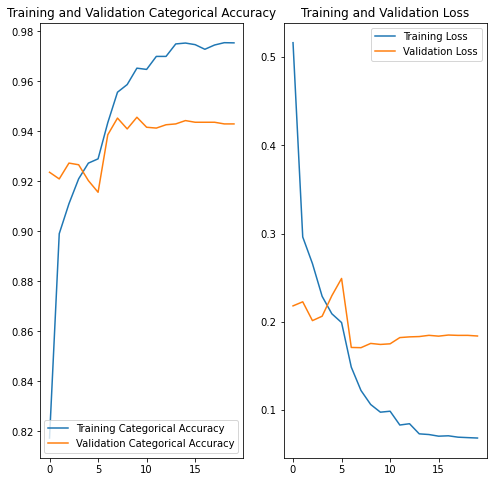

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()